In [1]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [3]:
def find_divide_indices(stim_table):
    '''
    Finds the indices where each new stimulus presentation after the first presentation
    starts.
    
    Returns:
        List of indices representing the start of the next stimulus
    '''
    # Find the indices where each new stimulus presentation after the first presentation starts
    divide_indices = []

    for i in range(min(stim_table.index), max(stim_table.index)):
        try:
            if stim_table.start[i+1]-stim_table.end[i] > 100:
                divide_indices.append(i) # saves index where new stim presentation begins
        except:
            pass
    return divide_indices

In [4]:
def divide_stim_table(stim_table, divide_indices=[]):
    '''
    Divides input stimulus table based on indices corresponding to separate stimulus
    presentations.
    If there were 3 presentations, three dataframes for each presentation are returned. 
    If there were 2 presentations, three dataframes for each presentation are still 
    returned with the third being null.
    
    Returns:
        3 divided stimulus tables corresponding to first, second, and third or null stimulus
        presentation start. 
    '''
    if len(divide_indices)==2: # 3 presentations 
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:divide_indices[1]], stim_table.loc[divide_indices[1]+1:]
    elif len(divide_indices) == 1: # 2 presentations
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:], pd.DataFrame()
    else:
        raise Exception("Stimulis has only one presentation. Nothing to divide.")

In [5]:
def generate_response_matrices(stim_table, all_events):
    '''
    This function generates response matrices given an input stimulus table. 
    Stimulus table can be divided based on stimulus presentations, or undivided.
    
    Returns:
        orientation_matrix: 1D array with orientation value for each frame
        frequency_matrix: 1D array with frequency value for each frame
        response: matrix of shape (# cells, # stimuli, 60) with response of each
            cell to each stimulus over its presentation period of 60 frames 
    '''
    #stim_table = stim_table.reset_index(drop=True)
    if stim_table.stim_category[0] == "drifting_gratings": # need to split stim ID
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 60)) # 3d array for responses at each frame to each stimulus for each neuron
        stim_table = stim_table.reset_index(drop=True)
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+60] 
        return response
    elif stim_table.stim_category[0] == "static_gratings" or stim_table.stim_category[0] == "natural_scenes":
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 7)) # 3d array for responses at each frame to each stimulus for each neuron
        stim_table = stim_table.reset_index(drop=True)
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+7]
        return response
    
    
# OLD: natural scenes stimulus matrix
#         stimulus_matrix = np.zeros(len(stim_table))
#         null = np.zeros(1)
#         # Loop through each stimulus presentation, store its parameters
#         for i in range(len(stim_table)):
#             # extract orientation and temporal frequency info by splitting stimulus ID
#             stimulus_matrix[i] = stim_table.stim_id[i]

In [ ]:
def responses_per_stimulus(stim_table, response_matrix):
    '''
    response_matrix: contains all recorded responses in the divided time frame 
    '''
    responses_by_stimulus = pd.DataFrame(columns=["stim_id","response_matrix"])
    
    for stim_id in np.unique(stim_table.stim_id):
        temp_stim_id_df = stim_table[stim_table.stim_id==stim_id]
        # below we are indexing the responses in the response matrix corresponding to the target 
        # stim ID values. The indices of target stim ID may be greater than the response matrix 
        # size since we devided the stimulus tables based on when the presentation was shown.
        # So we subtract the indices of each target stim ID by the first index of the stim table, 
        # to normalize the values.
        response_stimulus_matrix = response_matrix[:,list(temp_stim_id_df.index-stim_table.index[0]),:]
        responses_by_stimulus.loc[len(responses_by_stimulus)] = [stim_id, response_stimulus_matrix]
    
    return responses_by_stimulus

In [6]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [7]:
# Select the relevant data for chosen container ID
desired_container_id = 688678764
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

# Get session IDs for each session
session_one_id = desired_container[0]["id"]

# load in session data for each session
session_one = boc.get_ophys_experiment_data(ophys_experiment_id=session_one_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_one_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_one_id)

In [8]:
drifting_gratings_table = stim_table[stim_table.stim_category == "drifting_gratings"]

In [114]:
divide_indices = find_divide_indices(drifting_gratings_table)
dg1, dg2, dg3 = divide_stim_table(drifting_gratings_table, divide_indices)

In [170]:
#stim_table = stim_table.reset_index(drop=True)
dg1 = dg1.reset_index(drop=True)
if dg1.stim_category[0] == "drifting_gratings": # VERIFIED
    # generate response matrix
    response1 = np.empty((len(all_events.index), len(dg1), 60)) # 3d array for responses at each frame to each stimulus for each neuron
    for i in range(len(dg1)): # for each stimulus
        for cell_index in range(len(all_events.index)): # for each cell
            response1[cell_index,i,:] = all_events.iloc[cell_index, dg1.start[i]:dg1.start[i]+60]

In [87]:
#stim_table = stim_table.reset_index(drop=True)
dg2 = dg2.reset_index(drop=True)
if dg2.stim_category[0] == "drifting_gratings": # VERIFIED
    # generate response matrix
    response2 = np.empty((len(all_events.index), len(dg2), 60)) # 3d array for responses at each frame to each stimulus for each neuron
    for i in range(len(dg2)): # for each stimulus
        for cell_index in range(len(all_events.index)): # for each cell
            response2[cell_index,i,:] = all_events.iloc[cell_index, dg2.start[i]:dg2.start[i]+60]

In [166]:
responses_by_stimulus2 = pd.DataFrame(columns=["stim_id","response_matrix"])

for stim_id in np.unique(dg2.stim_id):
    dg2_reset=dg2.reset_index(drop=True)
    temp_stim_id_df = dg2_reset[dg2_reset.stim_id==stim_id]
    response_stimulus_matrix = response2[:,list(temp_stim_id_df.index),:]
    responses_by_stimulus2.loc[len(responses_by_stimulus2)] = [stim_id, response_stimulus_matrix]

In [167]:
dg2_reset[dg2_reset.stim_id == '0.0_15.0_0.0']

,start,end,stim_id,stim_category
49,53152,53212,0.0_15.0_0.0,drifting_gratings
77,55687,55747,0.0_15.0_0.0,drifting_gratings
78,55777,55837,0.0_15.0_0.0,drifting_gratings
127,60213,60273,0.0_15.0_0.0,drifting_gratings
187,65662,65722,0.0_15.0_0.0,drifting_gratings


In [168]:
response2[0][127]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10525163,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [169]:
responses_by_stimulus2.response_matrix[1][0][3] 
# I think response matrix by stimulus is accurate too because of this result. compare with above

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10525163,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [73]:
all_events.iloc[0][736:796]
# response matrix is correct because the first cell, first stimulus, 11th response is equal to that in
# all events

736    0.000000
737    0.000000
738    0.000000
739    0.000000
740    0.000000
741    0.000000
742    0.000000
743    0.000000
744    0.000000
745    0.000000
746    0.000000
747    0.167026
748    0.000000
749    0.000000
750    0.000000
751    0.000000
752    0.000000
753    0.000000
754    0.000000
755    0.000000
756    0.000000
757    0.000000
758    0.000000
759    0.000000
760    0.000000
761    0.000000
762    0.000000
763    0.000000
764    0.000000
765    0.000000
766    0.000000
767    0.000000
768    0.000000
769    0.000000
770    0.000000
771    0.000000
772    0.000000
773    0.000000
774    0.000000
775    0.000000
776    0.000000
777    0.000000
778    0.000000
779    0.000000
780    0.000000
781    0.000000
782    0.000000
783    0.000000
784    0.000000
785    0.000000
786    0.000000
787    0.000000
788    0.000000
789    0.000000
790    0.000000
791    0.000000
792    0.000000
793    0.000000
794    0.000000
795    0.000000
Name: 701728881, dtype: float64

In [172]:
responses_by_stimulus1 = pd.DataFrame(columns=["stim_id","response_matrix"])

for stim_id in np.unique(dg1.stim_id):
    dg1_reset=dg1.reset_index(drop=True)
    temp_stim_id_df = dg1_reset[dg1_reset.stim_id==stim_id]
    response_stimulus_matrix = response1[:,list(temp_stim_id_df.index),:]
    responses_by_stimulus1.loc[len(responses_by_stimulus1)] = [stim_id, response_stimulus_matrix]

In [178]:
#stim_table = stim_table.reset_index(drop=True)
dg3 = dg3.reset_index(drop=True)
if dg3.stim_category[0] == "drifting_gratings": # VERIFIED
    # generate response matrix
    response3 = np.empty((len(all_events.index), len(dg3), 60)) # 3d array for responses at each frame to each stimulus for each neuron
    for i in range(len(dg3)): # for each stimulus
        for cell_index in range(len(all_events.index)): # for each cell
            response3[cell_index,i,:] = all_events.iloc[cell_index, dg3.start[i]:dg3.start[i]+60]
            
responses_by_stimulus3 = pd.DataFrame(columns=["stim_id","response_matrix"])

for stim_id in np.unique(dg3.stim_id):
    dg3_reset=dg3.reset_index(drop=True)
    temp_stim_id_df = dg3_reset[dg3_reset.stim_id==stim_id]
    response_stimulus_matrix = response3[:,list(temp_stim_id_df.index),:]
    responses_by_stimulus3.loc[len(responses_by_stimulus3)] = [stim_id, response_stimulus_matrix]

In [173]:
# Try PCA first on one stimulus 
test_pca_results_dict = {}

test=responses_by_stimulus1[responses_by_stimulus1.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test = np.reshape(test, (test.shape[0],test.shape[1]*test.shape[2])).T
print(test.shape)

pca = PCA(n_components=2) # create PCA model
test_transformed_data = pca.fit_transform(test) # fit the model with the dataset
test_components = pca.components_ # list of principal components (PCs)
test_explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
test_pca_results_dict["0.0_1.0_0.0"] = {"components": test_components, "explained_variance_ratio": test_explained_variance_ratio} # add results to dictionary
test_pca_results = pd.DataFrame(test_pca_results_dict).T # make a DataFrame

(240, 475)


Text(0.5, 1.0, 'Drifting Gratings Stimulus 0.0_1.0_0.0 Session 1 PCA Analysis')

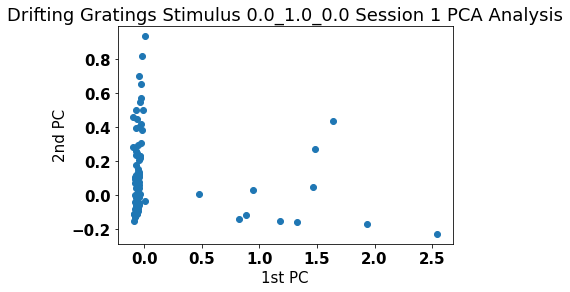

In [174]:
plt.scatter(test_transformed_data[:,0], test_transformed_data[:,1])
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_1.0_0.0 Session 1 PCA Analysis")# Try PCA first on one stimulus, session 2, on session 1 model 
test_pca_results_dict = {}

test=dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test = np.reshape(test, (test.shape[0],test.shape[1]*test.shape[2])).T
print(test.shape)

#pca = PCA(n_components=2) # create PCA model
test_transformed_data = pca.transform(test) # fit the model with the dataset
test_components = pca.components_ # list of principal components (PCs)
test_explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
test_pca_results_dict["0.0_1.0_0.0"] = {"components": test_components, "explained_variance_ratio": test_explained_variance_ratio} # add results to dictionary
test_pca_results = pd.DataFrame(test_pca_results_dict).T # make a DataFrameplt.scatter(test_transformed_data[:,0], test_transformed_data[:,1],cmap=)

plt.scatter(test_transformed_data[:,0], test_transformed_data[:,1])
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_1.0_0.0 Session 2 PCA Analysis Fit on Session 1")


(240, 475)


Text(0.5, 1.0, 'Drifting Gratings Stimulus 0.0_1.0_0.0 Session 2 PCA Analysis Fit on Session 1')

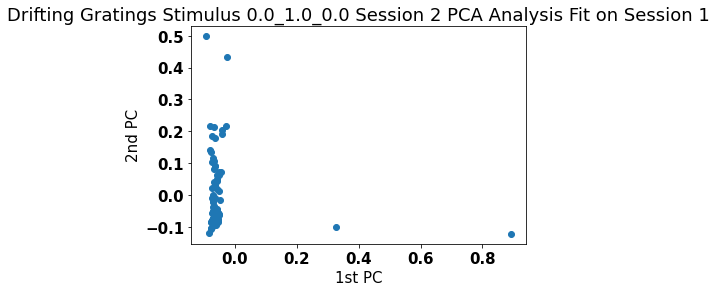

In [176]:
# Try PCA first on one stimulus, session 2, on session 1 model 
test_pca_results_dict = {}

test=responses_by_stimulus2[responses_by_stimulus2.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test = np.reshape(test, (test.shape[0],test.shape[1]*test.shape[2])).T
print(test.shape)

#pca = PCA(n_components=2) # create PCA model
test_transformed_data = pca.transform(test) # fit the model with the dataset
test_components = pca.components_ # list of principal components (PCs)
test_explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
test_pca_results_dict["0.0_1.0_0.0"] = {"components": test_components, "explained_variance_ratio": test_explained_variance_ratio} # add results to dictionary
test_pca_results = pd.DataFrame(test_pca_results_dict).T # make a DataFrameplt.scatter(test_transformed_data[:,0], test_transformed_data[:,1],cmap=)

plt.scatter(test_transformed_data[:,0], test_transformed_data[:,1])
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_1.0_0.0 Session 2 PCA Analysis Fit on Session 1")


In [179]:
responses_by_stimulus = responses_by_stimulus1.copy()
responses_by_stimulus["response_matrix2"] = responses_by_stimulus2.response_matrix
responses_by_stimulus["response_matrix3"] = responses_by_stimulus3.response_matrix

In [180]:
# Calculate mean responses for each stimulus
means = pd.DataFrame(columns=["stim_id", "mean1", "mean2", "mean3"])

index=0
for stim_id in np.unique(responses_by_stimulus.stim_id):
    matrix1 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix[index]
    matrix2 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix2[index]
    matrix3 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix3[index]

    mean1 = np.nanmean(matrix1)
    mean2 = np.nanmean(matrix2)
    mean3 = np.nanmean(matrix3)

    means.loc[len(means)] = [stim_id, mean1, mean2, mean3]
    index+=1

<ipython-input-180-01c8e3a2eece>:12: RuntimeWarning: Mean of empty slice
  mean3 = np.nanmean(matrix3)


In [181]:
heatmap_array_dg = np.asarray((list(means.mean1), list(means.mean2), list(means.mean3)))


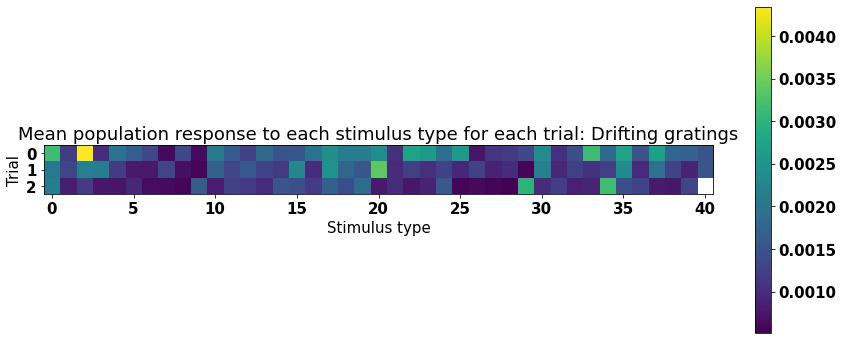

In [182]:
fig, ax = plt.subplots(figsize = (15,6))
im = ax.imshow(heatmap_array_dg)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Mean population response to each stimulus type for each trial: Drifting gratings")
plt.show()

# Drifting gratings stimuli are sometimes shown more times in a session than other sessions